<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Aprendizado

In [36]:
# # Instalar pt_BR
# !/usr/share/locales/install-language-pack pt_BR
# !dpkg-reconfigure locales

# import os

# # Reiniciar o Python
# os.kill(os.getpid(), 9)

# Importações

In [37]:
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, locale

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [38]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

# locale.setlocale(locale.LC_ALL, 'pt_BR')

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'
CORES  = ['#007F66', '#339966', '#66B266', '#99CC66', '#CCE566']

# COR_TREINO   = '#663399'
# COR_TESTE    = '#345cd3'
# COR_PREVISAO = '#f22424'

LINHA_ESPESSURA = 1

## Funções

In [39]:
def avaliar_previsoes(alvos, previsoes):

    print(classification_report(alvos, previsoes))

    ConfusionMatrixDisplay.from_predictions(alvos, previsoes, values_format='d', cmap=PALETA)
    plt.grid(False)

    relatorio = classification_report(alvos, previsoes, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def obter_conjunto(dados_treino, dados_validacao, q_modelos=10):

    conjunto = []

    for m in range(q_modelos):

        print(f'Modelo {m} de {q_modelos}.')

        modelo = Sequential()

        [modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
        modelo.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

        modelo.compile(loss=PERDA,
                       optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                       metrics=METRICAS)

        modelo.fit(dados_treino,
                   epochs=ITERACOES,
                   validation_data=dados_validacao,
                   verbose=0)
        
        conjunto.append(modelo)

    return conjunto

def obter_previsoes(conjunto, dados_validacao):
    
    previsoes = []

    for modelo in conjunto:
        previsoes.append(modelo.predict(dados_validacao, verbose=0))
    
    return tf.constant(tf.squeeze(previsoes))

def notificacoes_semanais(dados, local):

    ax = sns.lineplot(data=dados, x='Segunda-feira', y='Quantidade', linewidth=LINHA_ESPESSURA, color=CORES[0])

    plt.title(f'Notificações semanais para {local}')
    plt.xlabel('')
    plt.ylabel('Quantidade de Notificações')

    plt.xlim([datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)])

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.get_xticklabels(which='both'):
        tick.set_rotation(90)

    plt.grid(visible=True, which='both', axis='both')
    plt.show()

def criar_janelas(dados, janela_tamanho, horizonte_tamanho, premios=[]):

    # Array 2D de 0 a janela_tamanho + horizonte_tamanho.
    janela_primaria = np.expand_dims(np.arange(janela_tamanho + horizonte_tamanho), axis=0)

    # Array 2D com todas as janelas completas com os índices dos dados.
    indices = janela_primaria + np.expand_dims(np.arange(len(dados) - (janela_tamanho + horizonte_tamanho - 1)), axis=0).T

    # Dados em formato de janelas com horizontes.
    janelas_horizontes = dados[indices]

    # Separa os dados em janelas, horizonte.
    if len(premios) == 0:
        janelas = janelas_horizontes[:, :-horizonte_tamanho]
    else:
        janelas = np.column_stack((janelas_horizontes[:, :-horizonte_tamanho], premios[indices[:, -(horizonte_tamanho + 1)]]))

    horizontes = janelas_horizontes[:, -horizonte_tamanho:]

    return janelas, horizontes

def separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2):

    quantidade_teste = int(len(janelas) * (1 - tamanho_teste))

    janelas_treino    = janelas[:quantidade_teste]
    janelas_teste     = janelas[quantidade_teste:]
    horizontes_treino = horizontes[:quantidade_teste]
    horizontes_teste  = horizontes[quantidade_teste:]

    return janelas_treino, janelas_teste, horizontes_treino, horizontes_teste

def grafico_series(X_treino=[], y_treino=[],
                   X_teste=[], y_teste=[],
                   X_previsao=[], y_previsao=[],
                   inicio=0, fim=None):

    base_legenda = 1
    semanas = []

    if len(X_treino) > 0:
        sns.lineplot(x=X_treino[inicio:fim], y=y_treino[inicio:fim], color=CORES[0], linewidth=LINHA_ESPESSURA, label='Treino')
        semanas.append(X_treino[inicio:fim])
        base_legenda -= 0.06

    if len(X_teste) > 0:
        sns.lineplot(x=X_teste[inicio:fim], y=y_teste[inicio:fim], color=CORES[2], linewidth=LINHA_ESPESSURA, label='Teste')
        semanas.append(X_teste[inicio:fim])
        base_legenda -= 0.06

    if len(X_previsao) > 0:
        sns.lineplot(x=X_previsao[inicio:fim], y=y_previsao[inicio:fim], color=CORES[4], linewidth=LINHA_ESPESSURA, label='Previsão')
        semanas.append(X_previsao[inicio:fim])
        base_legenda -= 0.06

    semanas = np.unique(np.sort(semanas))

    plt.title(f'Notificações semanais')
    plt.xlabel('')
    plt.ylabel('Quantidade de Notificações')

    plt.xticks(ticks=semanas, labels=pd.to_datetime(semanas).strftime('%d/%m'), rotation=90)

    plt.legend(loc=(1.02, base_legenda), frameon=True, facecolor='white')

    plt.show()

def metricas_modelo(y_teste, y_previsao):

    mae = mean_absolute_error(y_teste, y_previsao)
    rmse = np.sqrt(mean_squared_error(y_teste, y_previsao))
    mape = mean_absolute_percentage_error(y_teste, y_previsao)

    return {'Mean Absolute Error': mae,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Percentage Error': mape}

# Aprendizado

## Classificação de diagnóstico de COVID-19 a partir de sintomas e fatores de risco

In [40]:
covid_avaliacoes = [None] * 10

### Hiperparâmetros

In [41]:
LOTE_TAMANHO = 2048

CAMADAS = 4

CAMADA_UNIDADES      = 32
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

### Dados

In [ ]:
df_sintomas_covid = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas_covid.zip')

In [ ]:
df_sintomas_covid['COVID'].value_counts()

1    388617
0    196703
Name: COVID, dtype: int64

#### Separação dos dados de treino e teste

In [ ]:
X = df_sintomas_covid.drop('COVID', axis=1)
y = df_sintomas_covid['COVID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

#### Datasets

In [ ]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

### Modelo 0: SKLearn Decision Tree

In [ ]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 2.92 s, sys: 44 ms, total: 2.96 s
Wall time: 5.96 s


              precision    recall  f1-score   support

           0       0.52      0.32      0.39     19737
           1       0.71      0.85      0.77     38795

    accuracy                           0.67     58532
   macro avg       0.62      0.58      0.58     58532
weighted avg       0.65      0.67      0.65     58532



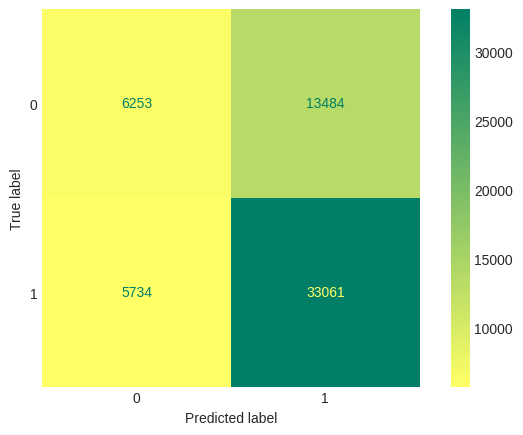

In [ ]:
covid_avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

### Modelo 1: SKLearn Random Forest

In [ ]:
%%time

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 33.6 s, sys: 252 ms, total: 33.9 s
Wall time: 41.3 s


              precision    recall  f1-score   support

           0       0.55      0.29      0.38     19737
           1       0.71      0.88      0.78     38795

    accuracy                           0.68     58532
   macro avg       0.63      0.58      0.58     58532
weighted avg       0.65      0.68      0.65     58532



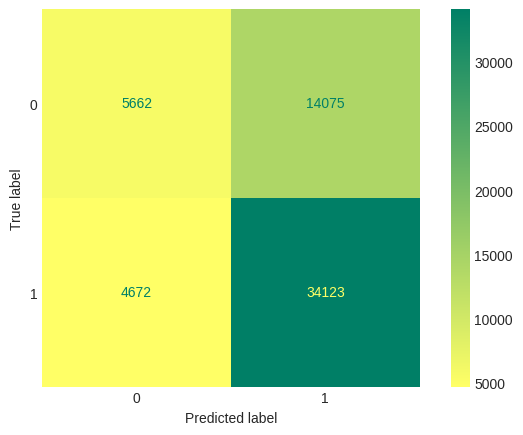

In [ ]:
covid_avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

### Modelo 2: SKLearn AdaBoost

In [ ]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 13.1 s, sys: 995 ms, total: 14.1 s
Wall time: 14.1 s


              precision    recall  f1-score   support

           0       0.58      0.23      0.33     19737
           1       0.70      0.92      0.79     38795

    accuracy                           0.68     58532
   macro avg       0.64      0.57      0.56     58532
weighted avg       0.66      0.68      0.64     58532



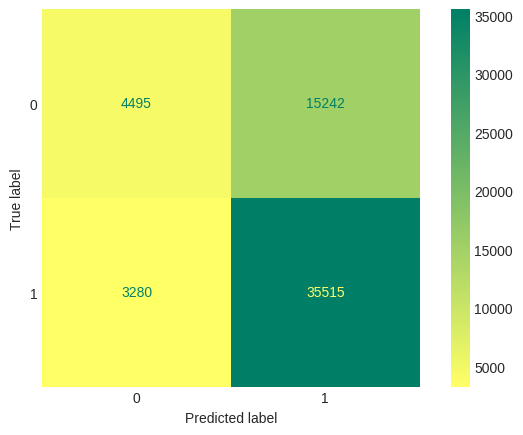

In [ ]:
covid_avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

### Modelo 3: SKLearn Gradient Boosting

In [ ]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 22.9 s, sys: 57.3 ms, total: 23 s
Wall time: 23 s


              precision    recall  f1-score   support

           0       0.59      0.26      0.36     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.58      0.58     58532
weighted avg       0.67      0.69      0.65     58532



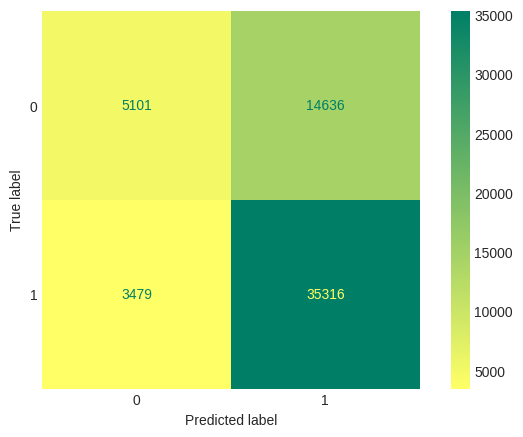

In [ ]:
covid_avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

### Modelo 4: XGBoost

In [ ]:
%%time

xgb = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 1min, sys: 189 ms, total: 1min
Wall time: 34.6 s


              precision    recall  f1-score   support

           0       0.60      0.27      0.37     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



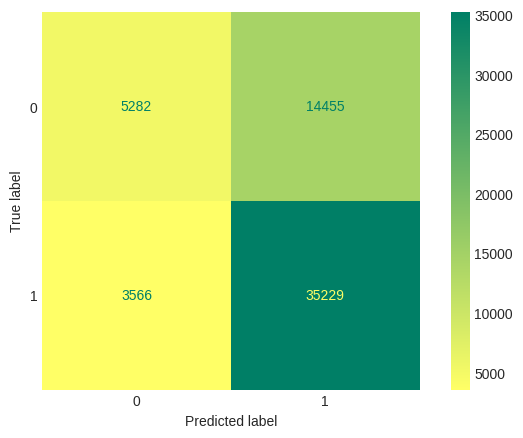

In [ ]:
covid_avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

### Modelo 5: TensorFlow Dense

In [ ]:
%%time

tf.random.set_seed(SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 2min 29s, sys: 4.52 s, total: 2min 34s
Wall time: 1min 51s


              precision    recall  f1-score   support

           0       0.59      0.27      0.37     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



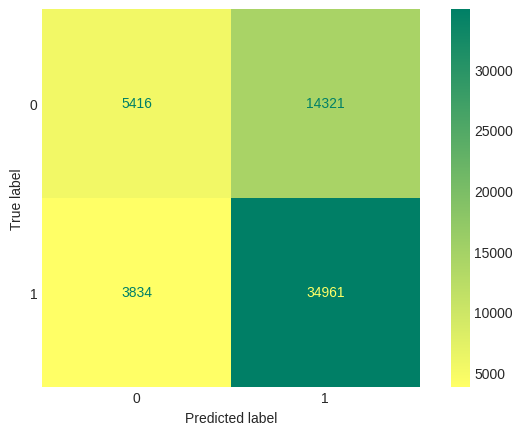

In [ ]:
covid_avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

### Modelo 6: TensorFlow Profound

In [ ]:
%%time

tf.random.set_seed(SEMENTE)

tfp = Sequential()

[tfp.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS ** 3)]
tfp.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfp.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfp.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfp.predict(dataset_test, verbose=0))

CPU times: user 5min 40s, sys: 5.73 s, total: 5min 46s
Wall time: 4min 8s


              precision    recall  f1-score   support

           0       0.60      0.23      0.34     19737
           1       0.70      0.92      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.58      0.57     58532
weighted avg       0.67      0.69      0.64     58532



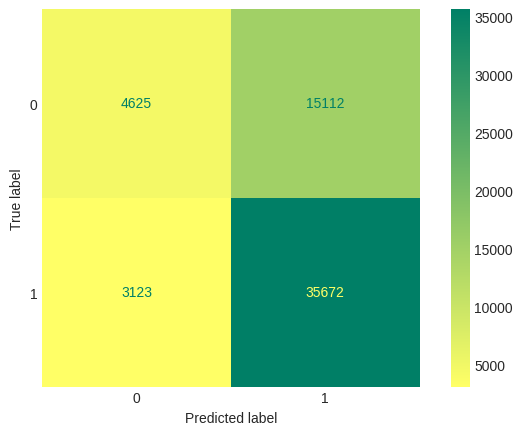

In [ ]:
covid_avaliacoes[6] = avaliar_previsoes(y_test, y_pred)

### Modelo 7: TensorFlow Ensemble

In [ ]:
%%time

conjunto = obter_conjunto(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5)

Modelo 0 de 5.
Modelo 1 de 5.
Modelo 2 de 5.
Modelo 3 de 5.
Modelo 4 de 5.
CPU times: user 12min 25s, sys: 20.7 s, total: 12min 46s
Wall time: 8min 53s


In [ ]:
previsoes = obter_previsoes(conjunto=conjunto, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



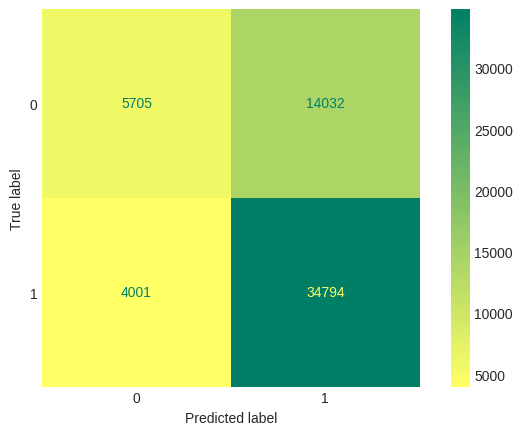

In [ ]:
covid_avaliacoes[7] = avaliar_previsoes(y_test, y_pred)

### Comparação de modelos

In [ ]:
comparacao = pd.DataFrame([a for a in covid_avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

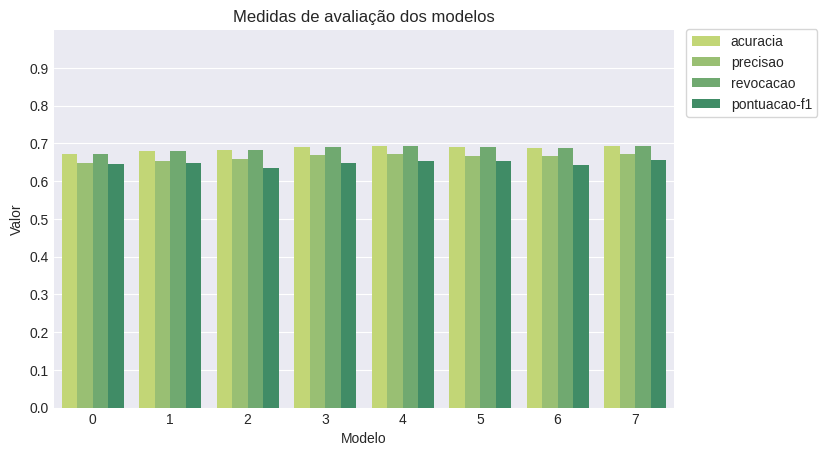

In [ ]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.ylim(0.0, 1.01)
plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.legend(loc=(1.02, 0.77), frameon=True, facecolor='white');

## Projeção de notificações

Projeção (time series) de notificações por local (detalhamento variável) pelas próximas 8 semanas.

In [104]:
metricas = [None] * 10

### Hiperparâmetros

In [105]:
LOTE_TAMANHO = 128

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 200

### Dados

In [106]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

#### Aleatórios

In [107]:
# uf_cod, uf_desc = df_populacao[['UF', 'Nome']].sample().values[0]
# print(f"UF: {uf_cod} - {uf_desc}")
# display(df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod][:5])
# notificacoes_semanais(df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod], f"{uf_cod} - {uf_desc}")

In [108]:
# mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']].sample().values[0]
# print(f"Município: {mu_cod} - {mu_desc}")
# display(df_notificacoes_por_municipio[df_notificacoes_por_municipio['Municipio'] == mu_cod][:5])
# notificacoes_semanais(df_notificacoes_por_municipio[df_notificacoes_por_municipio['Municipio'] == mu_cod], f"{mu_cod} - {mu_desc}")

In [109]:
# un_cod, un_desc = df_unidades[['Codigo', 'Unidade']].sample().values[0]
# print(f"Unidade: {un_cod} - {un_desc}")
# display(df_notificacoes_por_unidade[df_notificacoes_por_unidade['Unidade'] == un_cod][:5])
# notificacoes_semanais(df_notificacoes_por_unidade[df_notificacoes_por_unidade['Unidade'] == un_cod], f"{un_cod} - {un_desc}")

#### Dados para testes

In [110]:
uf_cod  = 'RJ'
uf_desc = df_populacao['Nome'][df_populacao['UF'] == uf_cod].values[0]

dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
local = f"{uf_cod} - {uf_desc}"

quantidades = dados['Quantidade'].to_numpy()

# display(dados[:5])
# notificacoes_semanais(dados, local)

In [111]:
treino_tamanho = int(len(dados) * 0.8)  # 80% da base
treino_tamanho

89

In [112]:
X_train = dados[:treino_tamanho]['Segunda-feira'].to_numpy()
y_train = dados[:treino_tamanho]['Quantidade'].to_numpy()

X_test = dados[treino_tamanho:]['Segunda-feira'].to_numpy()
y_test = dados[treino_tamanho:]['Quantidade'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(89, 89, 23, 23)

### Modelo 1: Denso (7 janelas, 1 horizonte)

In [113]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [114]:
quantidades, len(quantidades)

(array([  28, 1219, 2486, 2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852,
        4970, 5556, 5420, 5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296,
        3930, 3443, 2808, 2740, 2615, 2705, 2620, 2527, 2435, 2730, 2900,
        3194, 2976, 2751, 2257, 1895, 1711, 1559, 1360, 1097,  931,  957,
         849,  849,  807,  856, 1181, 1390, 1615, 1464, 1491, 1321, 1850,
        2364, 2792, 1852, 1350, 1061,  764,  533,  675,  597,  552,  583,
         411,  462,  469,  581,  575,  638,  652,  822,  963, 1078, 1010,
        1301, 1185, 1053,  757,  637,  480,  433,  479,  419,  354,  321,
         283,  281,  282,  254,  252,  244,  251,  307,  369,  602,  866,
         829,  670,  574,  443,  305,  318,  292,  228,  181,  197,  169,
         148,   76]), 112)

In [115]:
janelas[:5], len(janelas)

(array([[  28, 1219, 2486, 2481, 2143, 2180, 2179],
        [1219, 2486, 2481, 2143, 2180, 2179, 2088],
        [2486, 2481, 2143, 2180, 2179, 2088, 2629],
        [2481, 2143, 2180, 2179, 2088, 2629, 2870],
        [2143, 2180, 2179, 2088, 2629, 2870, 3852]]), 105)

In [116]:
horizontes[:5], len(horizontes)

(array([[2088],
        [2629],
        [2870],
        [3852],
        [4970]]), 105)

In [117]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_1_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

[modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_relu_{c}')) for c in range(CAMADAS)]
modelo.add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=LOTE_TAMANHO,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', patience=50)],
           verbose=0)

previsoes = modelo.predict(janelas_teste, verbose=0)

CPU times: user 10.3 s, sys: 248 ms, total: 10.6 s
Wall time: 11.7 s


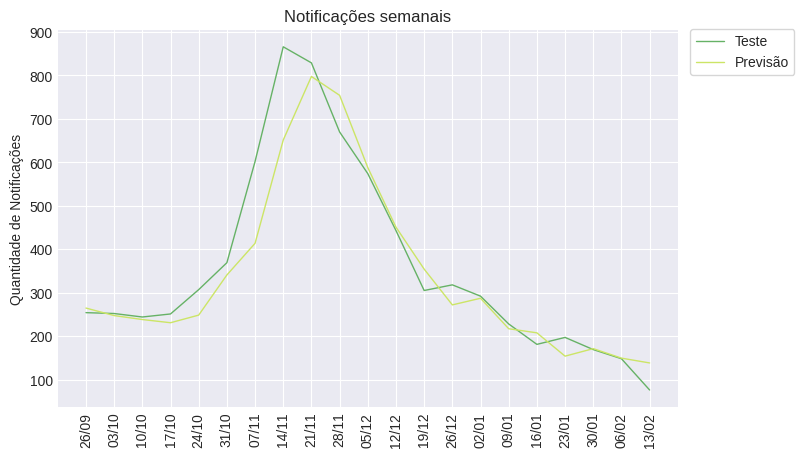

In [118]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
#                inicio=-60)

grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, 0],
               inicio=-60)

In [119]:
# metricas[1] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))
metricas[1] = metricas_modelo(horizontes_teste[:, 0], y_previsao=previsoes[:, 0])

In [120]:
metricas[1]

{'Mean Absolute Error': 43.58286830357143,
 'Root Mean Squared Error': 70.98683764434885,
 'Mean Absolute Percentage Error': 0.13219444811771788}

### Modelo 2: Denso (24 janelas, 8 horizontes)

In [121]:
janela_tamanho = 24
horizonte_tamanho = 8

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [122]:
quantidades, len(quantidades)

(array([  28, 1219, 2486, 2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852,
        4970, 5556, 5420, 5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296,
        3930, 3443, 2808, 2740, 2615, 2705, 2620, 2527, 2435, 2730, 2900,
        3194, 2976, 2751, 2257, 1895, 1711, 1559, 1360, 1097,  931,  957,
         849,  849,  807,  856, 1181, 1390, 1615, 1464, 1491, 1321, 1850,
        2364, 2792, 1852, 1350, 1061,  764,  533,  675,  597,  552,  583,
         411,  462,  469,  581,  575,  638,  652,  822,  963, 1078, 1010,
        1301, 1185, 1053,  757,  637,  480,  433,  479,  419,  354,  321,
         283,  281,  282,  254,  252,  244,  251,  307,  369,  602,  866,
         829,  670,  574,  443,  305,  318,  292,  228,  181,  197,  169,
         148,   76]), 112)

In [123]:
janelas[:5], len(janelas)

(array([[  28, 1219, 2486, 2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852,
         4970, 5556, 5420, 5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296,
         3930, 3443],
        [1219, 2486, 2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852, 4970,
         5556, 5420, 5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296, 3930,
         3443, 2808],
        [2486, 2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852, 4970, 5556,
         5420, 5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296, 3930, 3443,
         2808, 2740],
        [2481, 2143, 2180, 2179, 2088, 2629, 2870, 3852, 4970, 5556, 5420,
         5752, 4808, 4669, 4756, 4370, 4458, 4388, 4296, 3930, 3443, 2808,
         2740, 2615],
        [2143, 2180, 2179, 2088, 2629, 2870, 3852, 4970, 5556, 5420, 5752,
         4808, 4669, 4756, 4370, 4458, 4388, 4296, 3930, 3443, 2808, 2740,
         2615, 2705]]), 81)

In [124]:
horizontes[:5], len(horizontes)

(array([[2808, 2740, 2615, 2705, 2620, 2527, 2435, 2730],
        [2740, 2615, 2705, 2620, 2527, 2435, 2730, 2900],
        [2615, 2705, 2620, 2527, 2435, 2730, 2900, 3194],
        [2705, 2620, 2527, 2435, 2730, 2900, 3194, 2976],
        [2620, 2527, 2435, 2730, 2900, 3194, 2976, 2751]]), 81)

In [125]:
len(janelas_treino), len(janelas_teste), len(horizontes_treino), len(horizontes_teste)

(64, 17, 64, 17)

In [126]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_2_denso_24j_8h'

modelo = Sequential(name=modelo_nome)

[modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_relu_{c}')) for c in range(CAMADAS)]
modelo.add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=LOTE_TAMANHO,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', patience=50)],
           verbose=0)

previsoes = modelo.predict(janelas_teste, verbose=0)

CPU times: user 11.5 s, sys: 327 ms, total: 11.8 s
Wall time: 22.4 s


In [127]:
X_test[-len(janelas_teste):]

array(['2022-10-24T00:00:00.000000000', '2022-10-31T00:00:00.000000000',
       '2022-11-07T00:00:00.000000000', '2022-11-14T00:00:00.000000000',
       '2022-11-21T00:00:00.000000000', '2022-11-28T00:00:00.000000000',
       '2022-12-05T00:00:00.000000000', '2022-12-12T00:00:00.000000000',
       '2022-12-19T00:00:00.000000000', '2022-12-26T00:00:00.000000000',
       '2023-01-02T00:00:00.000000000', '2023-01-09T00:00:00.000000000',
       '2023-01-16T00:00:00.000000000', '2023-01-23T00:00:00.000000000',
       '2023-01-30T00:00:00.000000000', '2023-02-06T00:00:00.000000000',
       '2023-02-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [128]:
horizontes_teste[:, 0]

array([283, 281, 282, 254, 252, 244, 251, 307, 369, 602, 866, 829, 670,
       574, 443, 305, 318])

In [129]:
previsoes[:, 0]

array([334.05185, 316.12872, 368.01755, 404.04602, 363.2126 , 383.6858 ,
       383.46674, 377.19006, 336.4977 , 522.42883, 585.0569 , 720.28046,
       793.5827 , 584.03845, 428.95218, 314.06897, 236.70909],
      dtype=float32)

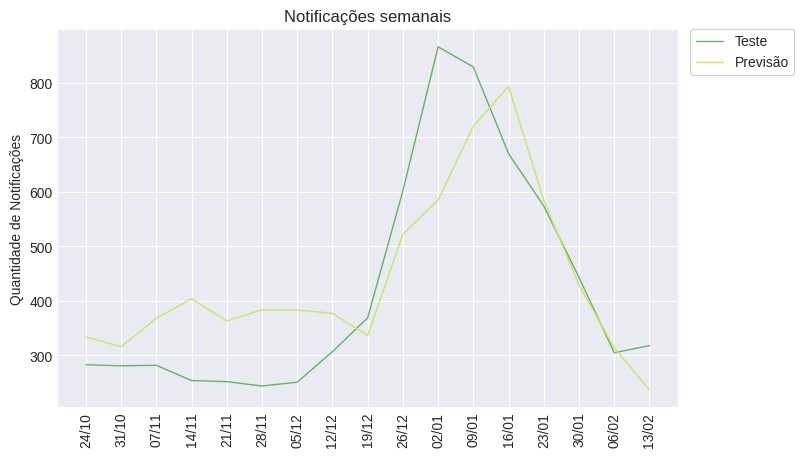

In [130]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
#                inicio=-60)

grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, 0],
               inicio=-60)

In [131]:
# metricas[2] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))
metricas[2] = metricas_modelo(horizontes_teste[:, 0], y_previsao=previsoes[:, 0])

In [132]:
metricas[2]

{'Mean Absolute Error': 89.15084031048943,
 'Root Mean Squared Error': 110.74766829232196,
 'Mean Absolute Percentage Error': 0.24507032592447842}

### Comparação dos modelos

In [133]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1
Mean Absolute Error,43.582868,89.150840
Root Mean Squared Error,70.986838,110.747668
Mean Absolute Percentage Error,0.132194,0.245070


In [134]:
df_metricas['Mean Absolute Error'].sort_values()

0    43.582868
1    89.150840
Name: Mean Absolute Error, dtype: float64